In [39]:
import os
import glob
import json
from pathlib import Path

import torch
from data_aug.utils import set_seeds
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

from src.data_aug.utils import set_seeds
from src.data_aug.models import LeNet
from src.data_aug.models.mlp import MLP
from src.data_aug.datasets import get_mnist

ModuleNotFoundError: No module named 'data_aug'

In [ ]:
[ 3048 19563 58303  8870 40228 31488 21860 56864   845 25770]

In [ ]:
# local
samples_dir = "./wandb/"
samples_dir = [f.path for f in os.scandir(samples_dir) if f.is_dir()]
# samples_dir.remove('./samples/wandb/latest-run')

In [116]:
# remote
samples_dir = "./wandb/"
samples_dir = [f.path for f in os.scandir(samples_dir) if f.is_dir()]
# samples_dir.remove("./wandb/latest-run")

this_aug = "False"
this_replacement = "False"
this_perm = "False"
this_dirty_lik='lenet'
this_prior_scale = 1.0
this_T_logit = 1.0

dict_sample_dir = {}
Ts = [0.286, 0.333, 0.4, 0.5, 0.667, 1.0, 2.0]

for sample_dir in samples_dir:
    config_dir = f"{sample_dir}/files/wandb-metadata.json"
    with open(config_dir) as json_file:
        sample_config = json.load(json_file)["args"]

    T = float(sample_config[0].split("=")[-1])
    aug = sample_config[1].split("=")[-1]
    replacement = sample_config[2].split("=")[-1]
    perm = sample_config[3].split("=")[-1]
    dirty_lik=sample_config[7].split("=")[-1]
    T_logit = float(sample_config[10].split("=")[-1])
    prior_scale = float(sample_config[12].split("=")[-1])
    if T in Ts:
        if (
            aug == this_aug
            and replacement == this_replacement
            and perm == this_perm
            and dirty_lik == this_dirty_lik
            and prior_scale == this_prior_scale
            and T_logit == this_T_logit
        ):
            dict_sample_dir[T] = sample_dir
            print(T)
            print(sample_dir)
print(dict_sample_dir)

for T in Ts:
    n=0
    for log_p_path in Path(dict_sample_dir[T]).rglob("log_p_train*.pt"):
        n+=1
    if n!=10:
        print(T,n)
    n=0
    for log_p_path in Path(dict_sample_dir[T]).rglob("log_p_test*.pt"):
        n+=1
    if n!=10:
        print(T,n)

FileNotFoundError: [Errno 2] No such file or directory: './wandb/'

In [15]:
bool(this_aug)

True

In [14]:
this_aug = "True"

In [79]:
# dict_sample_dir = {}
# Ts = [0.286, 0.333, 0.4, 0.5, 0.667, 1.0, 2.0]

# this_T_logit=5.0
# this_prior_scale=0.001
# for sample_dir in samples_dir:
#     config_dir = f"{sample_dir}/files/wandb-metadata.json"
#     with open(config_dir) as json_file:
#         sample_config = json.load(json_file)["args"]

#     T = float(sample_config[0].split("=")[-1])
#     aug=sample_config[1].split("=")[-1]
#     replacement=sample_config[2].split("=")[-1]
#     perm=sample_config[3].split("=")[-1]
#     T_logit = float(sample_config[10].split("=")[-1])
#     prior_scale = float(sample_config[12].split("=")[-1])
#     if T in Ts:
#         if prior_scale==this_prior_scale and T_logit==this_T_logit:
#             dict_sample_dir[T]=sample_dir
# T_logit=1.0
# print(dict_sample_dir)

2.0 52
0.333 52
0.286 52
0.4 52
1.0 52
0.667 52
0.5 52


In [ ]:
for 

In [ ]:
dict_sample_dir = {}
Ts = [0.286, 0.333, 0.4, 0.5, 0.667, 1.0, 2.0]

for sample_dir in samples_dir:
    config_dir = f"{sample_dir}/files/wandb-metadata.json"
    with open(config_dir) as json_file:
        sample_config = json.load(json_file)["args"]
    aug = sample_config[1].split("=")[-1]
    replacement = sample_config[2].split("=")[-1]
    perm = sample_config[3].split("=")[-1]
    T = float(sample_config[0].split("=")[-1])
    if T in Ts:
        if aug == "False" and replacement == "False" and perm == "True":
            dict_sample_dir[T] = sample_dir

print(dict_sample_dir)

In [75]:
dict_sample_dir

{}

In [72]:
dict_sample_dir[1.0]

'./samples/wandb/offline-run-20230512_123822-e6c2r7wu'

In [60]:
@torch.no_grad()
def get_logits(net, data_loader, samples_dir, nll_criterion=None, device=None):
    net.eval()

    ens_logits = []

    n_sample = 0
    for sample_path in tqdm(Path(samples_dir).rglob("*.pt"), leave=False):
        net.load_state_dict(torch.load(sample_path))
        n_sample += 1

        all_logits = []
        all_Y = []
        for X, Y in tqdm(data_loader, leave=False):
            X, Y = X.to(device), Y.to(device)
            _logits = net(X)
            all_logits.append(_logits)
            all_Y.append(Y)

        all_logits = torch.cat(all_logits)
        all_Y = torch.cat(all_Y)

        ens_logits.append(all_logits)

    ens_logits = torch.stack(ens_logits)

    return ens_logits, all_Y, n_sample

In [ ]:
def get_loss():
    gibbs_train = []
    gibbs_test = []
    bayes_test = []
    Ts = list(dict_sample_dir.keys())
    Ts.sort(reverse=True)
    for T in Ts:
        all_log_p_train=[]
        
        for log_p_path in Path(dict_sample_dir[T]).rglob("log_p_train*.pt"):
            all_log_p_train.append(torch.load(log_p_path,map_location=torch.device('cpu')))
        all_log_p_train=torch.stack(all_log_p_train)
        if all_log_p_train.shape[0] != 10:
            print(T)
        all_log_p_test=[]
        for log_p_path in Path(dict_sample_dir[T]).rglob("log_p_test*.pt"):
            all_log_p_test.append(torch.load(log_p_path,map_location=torch.device('cpu')))
        all_log_p_test=torch.stack(all_log_p_test)
        if all_log_p_test.shape[0] != 10:
            print(T)

        g_train = -(all_log_p_train).mean().item()
        g_test = -(all_log_p_test).mean().item()
        gibbs_train.append(g_train)
        gibbs_test.append(g_test)
        b_test = (
            (
                torch.log(torch.tensor([all_log_p_test.shape[0]]))
                - torch.logsumexp(all_log_p_test, 0)
            )
            .mean()
            .item()
        )
        # b_test = torch.log(torch.tensor(len(dict_sample_dir[T]))) - torch.logsumexp(
        #     log_p_test, 1
        # )
        bayes_test.append(b_test)
        # print("g_train", g_train)
        # print("g_test", g_test)
        # print("b_test", b_test)
    print(gibbs_train)
    print(gibbs_test)
    print(bayes_test)


In [8]:

def get_loss():
    gibbs_train = []
    gibbs_test = []
    bayes_test = []
    Ts = list(dict_sample_dir.keys())
    Ts.sort(reverse=True)
    # perm="False"
    for T in Ts:
        samples_dir = dict_sample_dir[T]
        print(T)

        torch.backends.cudnn.benchmark = True

        device = 0
        device = (
            f"cuda:{device}" if (device >= 0 and torch.cuda.is_available()) else "cpu"
        )
        torch.manual_seed(0)        
        set_seeds(0)
        batch_size = 2048
        if this_aug == "True":
            b_aug = True
        else:
            b_aug = False
        if this_perm == "True":
            b_perm = True
        else:
            b_perm = False
        train_data, test_data = get_mnist(
            root="./mnist/", augment=b_aug, perm=b_perm
        )
        
        if this_replacement == "True":
            from torch.utils.data import RandomSampler
            from torch.utils.data import Subset
            import numpy as np
            import random

            G = torch.Generator()
            G.manual_seed(0)
            torch.manual_seed(0)
            set_seeds(0)
            np.random.seed(0)
            random.seed(0)
            n_train = train_data.targets.shape[0]
            idx = np.random.choice(
                np.arange(0, n_train, 1), int(n_train * 0.05), replace=False
            )

            subset_train = Subset(train_data, idx)
            sampler = RandomSampler(subset_train, replacement=True, num_samples=n_train)
            train_loader = DataLoader(
                subset_train,
                batch_size=batch_size,
                num_workers=2,
                sampler=sampler,
                generator=G,
            )
        else:
            train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=2)

        # train_data, test_data = get_mnist(root="./mnist/", augment=False)
        test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=2)

        net = MLP(num_classes=10).to(device).eval()
        train_ens_logits, train_all_Y, n_sample = get_logits(
            net, train_loader, samples_dir, device=device
        )
        test_ens_logits, test_all_Y, n_sample = get_logits(
            net, test_loader, samples_dir, device=device
        )
        train_ens_logits /= T_logit
        test_ens_logits /= T_logit
        log_p_train = (
            torch.distributions.Categorical(logits=train_ens_logits)
            .log_prob(train_all_Y)
            .T
        )
        log_p_test = (
            torch.distributions.Categorical(logits=test_ens_logits)
            .log_prob(test_all_Y)
            .T
        )

        g_train = (-log_p_train).mean().item()
        g_test = (-log_p_test).mean().item()
        gibbs_train.append(g_train)
        gibbs_test.append(g_test)
        # b_test = (
        #     (
        #         -torch.log(
        #             torch.exp(
        #                 torch.distributions.Categorical(logits=test_ens_logits).log_prob(
        #                     test_all_Y
        #                 )
        #             ).mean(0)
        #         )
        #     )
        #     .mean()
        #     .item()
        # )
        b_test = (
            (
                torch.log(torch.tensor([n_sample], device=device))
                - torch.logsumexp(log_p_test, 1)
            )
            .mean()
            .item()
        )
        # b_test = torch.log(torch.tensor(len(dict_sample_dir[T]))) - torch.logsumexp(
        #     log_p_test, 1
        # )
        bayes_test.append(b_test)
        print("g_train", g_train)
        print("g_test", g_test)
        print("b_test", b_test)
    print(gibbs_train)
    print(gibbs_test)
    print(bayes_test)

In [ ]:
1.0
./wandb/offline-run-20230514_153935-ddxb2csg
1.0
./wandb/offline-run-20230514_153700-oxfpmpn8
1.0
./wandb/offline-run-20230514_151930-ei4wpnsl
1.0
./wandb/offline-run-20230514_153830-et45hezh
dict_sample_dir={1.0: './wandb/offline-run-20230514_151930-ei4wpnsl'}

In [ ]:
no aug
[0.03050791099667549, 0.017226526513695717, 0.012891989201307297, 0.010158596560359001, 0.00900037121027708, 0.008118189871311188, 0.007524026557803154]
[0.05624280124902725, 0.049594417214393616, 0.043147195130586624, 0.044841453433036804, 0.045084040611982346, 0.044107332825660706, 0.04281942918896675]
[0.03128693997859955, 0.02747919224202633, 0.02638675831258297, 0.02769833244383335, 0.02888103574514389, 0.02813079208135605, 0.02839893475174904]

In [ ]:
aug
[
    0.11895960569381714,
    0.09043719619512558,
    0.07913712412118912,
    0.07387161999940872,
    0.07079873979091644,
    0.06731726229190826,
    0.06544224917888641,
]
[
    0.10629427433013916,
    0.08446022868156433,
    0.07686914503574371,
    0.07203002274036407,
    0.07021259516477585,
    0.06713411211967468,
    0.06490015238523483,
]
[
    0.07996584475040436,
    0.06522323191165924,
    0.060833897441625595,
    0.05806560441851616,
    0.05675897002220154,
    0.05485215783119202,
    0.053310494869947433,
]

In [ ]:
# replacement
[
    0.6858844757080078,
    0.5264888405799866,
    0.4435129761695862,
    0.4030664563179016,
    0.36030974984169006,
    0.3475649058818817,
    0.3386608958244324,
]
[
    0.6633772253990173,
    0.5016458630561829,
    0.4103488326072693,
    0.3672281801700592,
    0.33228468894958496,
    0.32155826687812805,
    0.3090495765209198,
]
[
    0.20064416527748108,
    0.1997184306383133,
    0.1952059417963028,
    0.19584240019321442,
    0.1961265653371811,
    0.19690988957881927,
    0.198279470205307,
]

# fig 2

In [112]:
# prior 0.01, gamma 1.0
g_train_001_1=[0.03160056471824646, 0.013118099421262741, 0.006885752081871033, 0.004398418590426445, 0.006548774428665638, 0.0024671831633895636, 0.004852390382438898]
# [0.06488003581762314, 0.061384979635477066, 0.06041676923632622, 0.0598638653755188, 0.049261823296546936, 0.04961521178483963, 0.044060930609703064]
b_test_001_1=[0.03475422039628029, 0.02912176586687565, 0.02581768126785755, 0.023713073253631592, 0.022876473307609558, 0.0217940214574337, 0.02147365766763687]

In [113]:
# prior 0.01, gamma 2.0
g_train_001_2=[0.0437370166182518, 0.02133895643055439, 0.013218909502029419, 0.011999712325632572, 0.01811063289642334, 0.024620410054922104, 0.02140321396291256]
# [0.1604093760251999, 0.14860887825489044, 0.130875825881958, 0.12874692678451538, 0.12399047613143921, 0.11778093129396439, 0.11806309223175049]
b_test_001_2 = [0.050297196954488754, 0.03471069782972336, 0.030280716717243195, 0.02768068201839924, 0.029908526688814163, 0.03813883662223816, 0.03722342103719711]

In [114]:
# prior 1.0, gamma 1.0
g_train_1_1=[0.03116486966609955, 0.012736449018120766, 0.006821766030043364, 0.004880605731159449, 0.003496240928769112, 0.0023003206588327885, 0.001910959486849606]
g_test_1_1=[0.06397750228643417, 0.06081245467066765, 0.06232388690114021, 0.05463981628417969, 0.04098547622561455, 0.060539666563272476, 0.06419405341148376]
b_test_1_1=[0.03426339104771614, 0.02880902774631977, 0.026559380814433098, 0.024743106216192245, 0.024880322515964508, 0.024976549670100212, 0.02703576348721981]

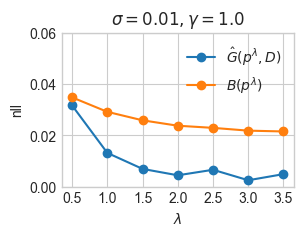

In [115]:
plt.figure(figsize=(3,2))
plt.plot(np.arange(0, len(lambs), 1),g_train_001_1, label=r"$\hat G(p^\lambda,D)$",marker="o")
plt.plot(np.arange(0, len(lambs), 1),b_test_001_1, label=r"$B(p^\lambda)$",marker="o")
plt.title(r"$\sigma=0.01, \gamma=1.0$")
plt.legend()
plt.xticks(np.arange(0, len(lambs), 1), lambs)
plt.xlabel(r"$\lambda$")
plt.ylim(0,0.06)
plt.ylabel("nll")
plt.plot()
plt.savefig(f"001_1.png", dpi=1000, bbox_inches='tight')


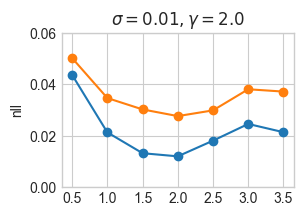

In [63]:
plt.figure(figsize=(3,2))
plt.plot(np.arange(0, len(lambs), 1),g_train_001_2, label=r"$\hat G(p^\lambda,D)$",marker="o")
plt.plot(np.arange(0, len(lambs), 1),b_test_001_2, label=r"$B(p^\lambda)$",marker="o")
plt.title(r"$\sigma=0.01, \gamma=2.0$")
# plt.legend()
plt.xticks(np.arange(0, len(lambs), 1), lambs)
plt.ylim(0,0.06)
plt.ylabel("nll")
plt.plot()
plt.savefig(f"001_2.png", dpi=1000, bbox_inches='tight')


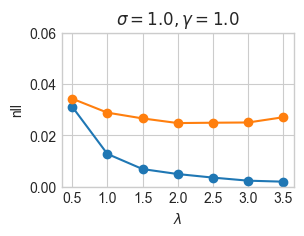

In [64]:
plt.figure(figsize=(3,2))
plt.plot(np.arange(0, len(lambs), 1),g_train_1_1, label=r"$\hat G(p^\lambda,D)$",marker="o")
plt.plot(np.arange(0, len(lambs), 1),b_test_1_1, label=r"$B(p^\lambda)$",marker="o")
plt.title(r"$\sigma=1.0, \gamma=1.0$")
# plt.legend()
plt.xticks(np.arange(0, len(lambs), 1), lambs)
plt.xlabel(r"$\lambda$")
plt.ylim(0,0.06)
plt.ylabel("nll")
plt.plot()
plt.savefig(f"1_1.png", dpi=1000, bbox_inches='tight')



In [4]:
import matplotlib.pyplot as plt

# aug results

In [4]:
# no aug
g_train_no=[0.03050791099667549, 0.017226526513695717, 0.012891989201307297, 0.010158596560359001, 0.00900037121027708, 0.008118189871311188, 0.007524026557803154]
g_test_no=[0.05624280124902725, 0.049594417214393616, 0.043147195130586624, 0.044841453433036804, 0.045084040611982346, 0.044107332825660706, 0.04281942918896675]
b_test_no=[0.031286969780921936, 0.02747921645641327, 0.02638677880167961, 0.027698354795575142, 0.028881056234240532, 0.02813081070780754, 0.02839895896613598]

In [5]:
# aug
g_train_aug=[0.1512414813041687, 0.11541778594255447, 0.10026060044765472, 0.09355244785547256, 0.08816760033369064, 0.08376327902078629, 0.08214880526065826]
g_test_aug=[0.10629427433013916, 0.08446022868156433, 0.07686914503574371, 0.07203002274036407, 0.07021259516477585, 0.06713411211967468, 0.06490015238523483]
b_test_aug=[0.07996588200330734, 0.06522326171398163, 0.06083393469452858, 0.05806563422083855, 0.05675900727510452, 0.0548521913588047, 0.05331053212285042]

In [81]:
# perm 
# [11.477632522583008, 14.5548734664917, 18.845388412475586, 18.946243286132812, 19.26655387878418, 19.194910049438477, 23.102380752563477]
g_train_perm=[0.10001451522111893, 0.040073979645967484, 0.020563695579767227, 0.012553473003208637, 0.008014500141143799, 0.00569415558129549, 0.0040769390761852264]
g_test_perm=[25.52706527709961, 30.47207260131836, 34.130435943603516, 35.28390884399414, 35.45931625366211, 36.6449089050293, 35.95731735229492]
b_test_perm=[11.398812294006348, 12.926487922668457, 14.643202781677246, 16.121671676635742, 16.059555053710938, 16.88193702697754, 17.13152503967285]

In [82]:
#replace

# [29.053586959838867, 23.52943992614746, 20.852951049804688, 19.116992950439453, 17.161989212036133, 17.04158592224121, 16.881254196166992]
# [0.6633772253990173, 0.5016458630561829, 0.4103488326072693, 0.3672281801700592, 0.33228468894958496, 0.32155826687812805, 0.3090495765209198]
# [0.20064418017864227, 0.1997184455394745, 0.19520597159862518, 0.195842444896698, 0.19612659513950348, 0.19690990447998047, 0.1982795149087906]

g_train_replace=[0.03119625151157379, 0.026744641363620758, 0.026689233258366585, 0.027509203180670738, 0.024783844128251076, 0.025041362270712852, 0.024873582646250725]
g_test_replace= [0.6633772253990173, 0.5016458630561829, 0.4103488326072693, 0.3672281801700592, 0.33228468894958496, 0.32155826687812805, 0.3090495765209198]
b_test_replace = [0.20064418017864227, 0.1997184455394745, 0.19520597159862518, 0.195842444896698, 0.19612659513950348, 0.19690990447998047, 0.1982795149087906]


In [83]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('seaborn-v0_8-whitegrid')

In [84]:
lambs = [0.5,1.0,1.5,2.0,2.5,3.0,3.5]

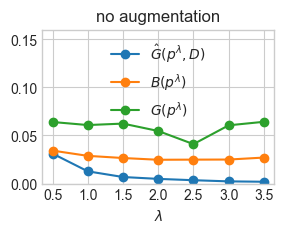

In [92]:
plt.figure(figsize=(3,2))
plt.plot(np.arange(0, len(lambs), 1),g_train_1_1, label=r"$\hat G(p^\lambda,D)$",marker="o")
plt.plot(np.arange(0, len(lambs), 1),b_test_1_1, label=r"$B(p^\lambda)$",marker="o")
plt.plot(np.arange(0, len(lambs), 1),g_test_1_1, label=r"$G(p^\lambda)$",marker="o")
plt.title("no augmentation")
plt.legend()
plt.xticks(np.arange(0, len(lambs), 1), lambs)
plt.xlabel(r"$\lambda$")
plt.ylim(0,0.16)
plt.plot()
plt.savefig(f"no_aug.png", dpi=1000, bbox_inches='tight')



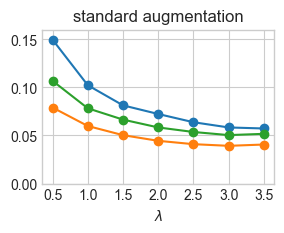

In [93]:
plt.figure(figsize=(3,2))
plt.plot(np.arange(0, len(lambs), 1),g_train_aug, label=r"$\hat G(p^\lambda,D)$",marker="o")
plt.plot(np.arange(0, len(lambs), 1),b_test_aug, label=r"$B(p^\lambda)$",marker="o")
plt.plot(np.arange(0, len(lambs), 1),g_test_aug, label=r"$G(p^\lambda)$",marker="o")
plt.title("standard augmentation")
# plt.legend()
plt.xticks(np.arange(0, len(lambs), 1), lambs)
plt.xlabel(r"$\lambda$")
plt.ylim(0,0.16)
plt.plot()
plt.savefig(f"aug.png", dpi=1000, bbox_inches='tight')

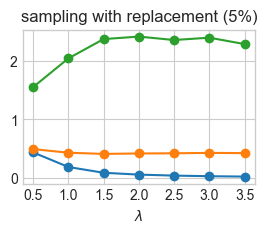

In [94]:
plt.figure(figsize=(3,2))
plt.plot(np.arange(0, len(lambs), 1),g_train_replace, label=r"$\hat G(p^\lambda,D)$",marker="o")
plt.plot(np.arange(0, len(lambs), 1),b_test_replace, label=r"$B(p^\lambda)$",marker="o")
plt.plot(np.arange(0, len(lambs), 1),g_test_replace, label=r"$G(p^\lambda)$",marker="o")
plt.title("sampling with replacement (5%)")
# plt.legend()
plt.xticks(np.arange(0, len(lambs), 1), lambs)
plt.xlabel(r"$\lambda$")
# plt.ylim(0,0.7)
plt.plot()
plt.savefig(f"replace.png", dpi=1000, bbox_inches='tight')


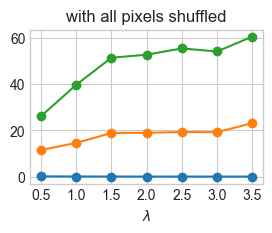

In [95]:
plt.figure(figsize=(3,2))
plt.plot(np.arange(0, len(lambs), 1),g_train_perm, label=r"$\hat G(p^\lambda,D)$",marker="o")
plt.plot(np.arange(0, len(lambs), 1),b_test_perm, label=r"$B(p^\lambda)$",marker="o")
plt.plot(np.arange(0, len(lambs), 1),g_test_perm, label=r"$G(p^\lambda)$",marker="o")
plt.title("with all pixels shuffled")
# plt.legend()
plt.xticks(np.arange(0, len(lambs), 1), lambs)
plt.xlabel(r"$\lambda$")
# plt.ylim(0,0.7)
plt.plot()
plt.savefig(f"perm.png", dpi=1000, bbox_inches='tight')


In [2]:
# [0.03160056471824646, 0.013118099421262741, 0.006885752081871033, 0.004398418590426445, 0.006548774428665638, 0.002467183396220207, 0.004852390382438898]
# [0.06488003581762314, 0.06138497591018677, 0.06041676923632622, 0.059863872826099396, 0.049261823296546936, 0.04961521178483963, 0.04406093806028366]
a=[0.0347541980445385, 0.02912173792719841, 0.02681765705347061, 0.026713049039244652, 0.023876473307609558, 0.023794027045369148, 0.02347373589873314]

In [3]:
# [0.0437370166182518, 0.02133895643055439, 0.013218909502029419, 0.011999712325632572, 0.01811063289642334, 0.024620410054922104, 0.02140321396291256]
# [0.06357795745134354, 0.047175947576761246, 0.04473420977592468, 0.04142237454652786, 0.03903492912650108, 0.03813883662223816, 0.03722342103719711]
b=[0.050297196954488754, 0.03471069782972336, 0.030280716717243195, 0.02768068201839924, 0.029908526688814163, 0.03813883662223816, 0.03722342103719711]

In [4]:
# [0.1991056501865387, 0.120464026927948, 0.23094302415847778, 0.1462426632642746, 0.22193850576877594, 0.21770143508911133, 0.19430840015411377]
# [0.203641876578331, 0.13090813159942627, 0.2441714107990265, 0.1531779170036316, 0.2221880555152893, 0.22083447873592377, 0.197875514626503]
c=[0.18964776396751404, 0.1200558990240097, 0.23039202392101288, 0.14611810445785522, 0.2221880555152893, 0.22083447873592377, 0.197875514626503]

In [5]:
# [0.03116486966609955, 0.012736449018120766, 0.006821766030043364, 0.004880606196820736, 0.015496240928769112, 0.0023003206588327885, 0.001910959486849606]
# [0.06397750973701477, 0.06081245094537735, 0.06232388690114021, 0.05463980883359909, 0.04098547622561455, 0.06053966283798218, 0.06419405341148376]
d=[0.03426336497068405, 0.02880900353193283, 0.026559356600046158, 0.024743083864450455, 0.029880322515964508, 0.02497652918100357, 0.02703574299812317]

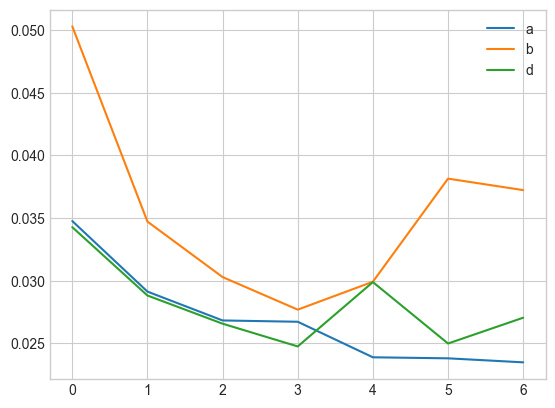

In [8]:
plt.plot(a,label="a")
plt.plot(b,label="b")
# plt.plot(c,label="c")
plt.plot(d,label="d")
plt.legend()

In [ ]:
[2.31306529045105, 2.3115885257720947, 2.3101179599761963, 2.308645009994507, 2.3071770668029785, 2.3057026863098145, 2.304257869720459]
[2.3035812377929688, 2.302727460861206, 2.30187726020813, 2.3010263442993164, 2.3001785278320312, 2.2993271350860596, 2.298492908477783]
[2.3033082485198975, 2.3024487495422363, 2.301591634750366, 2.3007333278656006, 2.299877643585205, 2.2990176677703857, 2.2981746196746826]

In [89]:
g_train_aug=[0.14951498806476593, 0.1021890789270401, 0.08127208054065704, 0.07229574769735336, 0.06373859941959381, 0.058324310928583145, 0.057244960218667984]
g_test_aug=[0.10673864930868149, 0.07821321487426758, 0.06645368039608002, 0.05832863226532936, 0.05360261723399162, 0.05037078633904457, 0.051690928637981415]
b_test_aug=[0.0790165364742279, 0.059825342148542404, 0.050306934863328934, 0.044432107359170914, 0.04094813019037247, 0.03922838717699051, 0.040583133697509766]

In [90]:
g_train_replace=[0.4370851516723633, 0.18750184774398804, 0.08893163502216339, 0.057394277304410934, 0.040452949702739716, 0.03010360337793827, 0.023699704557657242]
g_test_replace=[1.5546000003814697, 2.0454933643341064, 2.375391960144043, 2.418093681335449, 2.359375238418579, 2.3994898796081543, 2.289661169052124]
b_test_replace=[0.4935140013694763, 0.4316908121109009, 0.4114181101322174, 0.4190835952758789, 0.4218883216381073, 0.4288199245929718, 0.4250813126564026]

In [91]:
g_train_perm=[0.10001451522111893, 0.040073979645967484, 0.020563695579767227, 0.012553473003208637, 0.008014500141143799, 0.00569415558129549, 0.0040769390761852264]

g_test_perm=[26.06328010559082, 39.656463623046875, 51.3713493347168, 52.70551681518555, 55.4055290222168, 54.08025360107422, 60.528289794921875]

b_test_perm=[11.477632522583008, 14.5548734664917, 18.845388412475586, 18.946243286132812, 19.26655387878418, 19.194910049438477, 23.102380752563477]

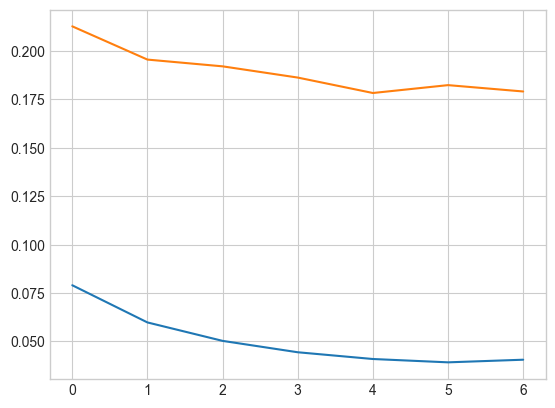

In [43]:
plt.plot(a)
plt.plot(b)
# plt.plot(c)